KNN Model Based for Collaborative Filtering

In [ ]:
import pandas as pd
import numpy as np

from scipy.sparse import csr_matrix
from sklearn.neighbors import NearestNeighbors

import matplotlib.pyplot as plt
import seaborn as sns

movies = pd.read_csv("movies.csv")
ratings = pd.read_csv("ratings.csv")

In [ ]:
ratings.head()

,userId,movieId,rating,timestamp
0,1,31,2.5,1260759144
1,1,1029,3.0,1260759179
2,1,1061,3.0,1260759182
3,1,1129,2.0,1260759185
4,1,1172,4.0,1260759205


In [ ]:
movies.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [ ]:
num_users = len(ratings.userId.unique())
num_items = len(ratings.movieId.unique())
print('Terdapat {} user unik, dan {} movie unik di dataset'.format(num_users, num_items))

Terdapat 671 user unik, dan 9066 movie unik di dataset


# Running Data Analysis:

1. Plot the counts of each rating
2. Plot rating frequency of each movie

<b>Plotting count of each rating</b>

In [ ]:
# mendapatkan hasil penghitungan rating
ratings_cnt_tmp = pd.DataFrame(ratings.groupby('rating').size(), columns=['count'])
# dataframe tidak punya 0 sebagai rating, dengan demikian code ini memasukkan rating 0 untuk unrated movie
total_cnt = num_users * num_items
rating_zero_cnt = total_cnt - ratings.shape[0]
# tambahkan penghitungan dari rating 0 ke df_ratings_cnt
ratings_cnt = ratings_cnt_tmp.append(
    pd.DataFrame({'count': rating_zero_cnt}, index=[0.0]),
    verify_integrity=True,
).sort_index()
ratings_cnt

,count
0.0,5983282
0.5,1101
1.0,3326
1.5,1687
2.0,7271
2.5,4449
3.0,20064
3.5,10538
4.0,28750
4.5,7723


Seperti yang bisa kita lihat, jumlah peringkat 0 atau yang tidak diberi peringkat jauh lebih banyak dibandingkan dengan peringkat gabungan lainnya.
<br>
Untuk visualisasi, kita dapat menggunakan grafik log untuk membandingkan angka-angka ini.

Text(0, 0.5, 'jumlah rating')

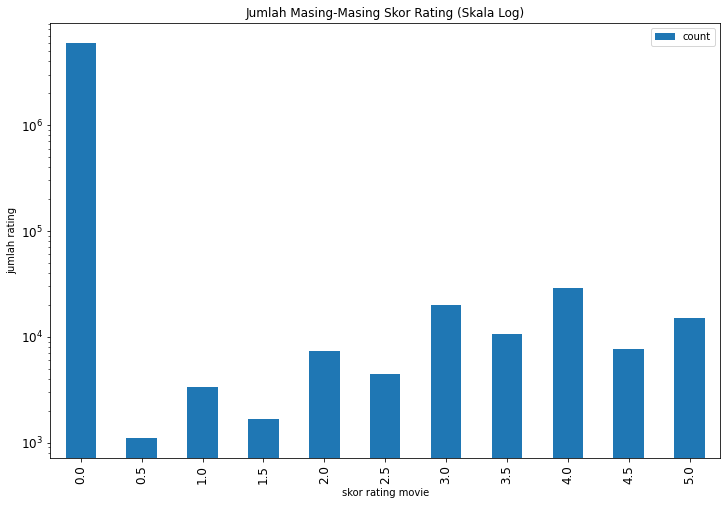

In [ ]:
ax = ratings_cnt[['count']].reset_index().rename(columns={'index': 'rating score'}).plot(
    x='rating score',
    y='count',
    kind='bar',
    figsize=(12, 8),
    title='Jumlah Masing-Masing Skor Rating (Skala Log)',
    logy=True,
    fontsize=12,
)
ax.set_xlabel("skor rating movie")
ax.set_ylabel("jumlah rating")

<b>Plotting rating frequency of each movie</b>

Text(0, 0.5, 'jumlah rating')

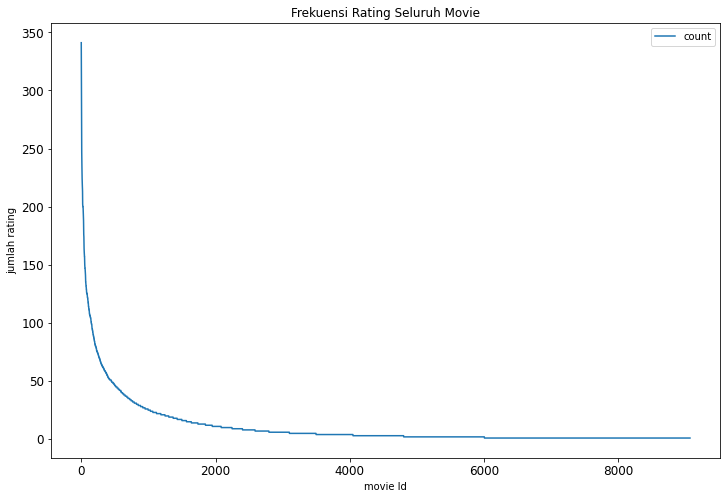

In [ ]:
movies_cnt = pd.DataFrame(ratings.groupby('movieId').size(), columns=['count'])
# plot frekuensi rating seluruh movie
ax = movies_cnt \
    .sort_values('count', ascending=False) \
    .reset_index(drop=True) \
    .plot(
        figsize=(12, 8),
        title='Frekuensi Rating Seluruh Movie',
        fontsize=12
    )
ax.set_xlabel("movie Id")
ax.set_ylabel("jumlah rating")

Text(0, 0.5, 'jumlah rating (skala log)')

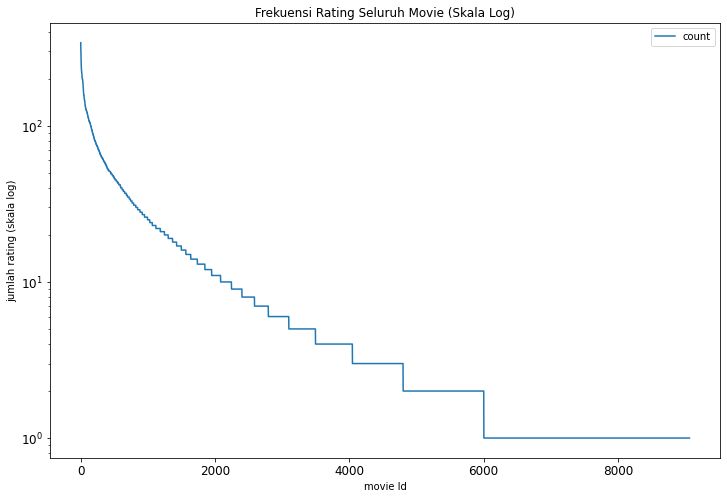

In [ ]:
# plot frekuensi rating seluruh movie di skala log
ax = movies_cnt \
    .sort_values('count', ascending=False) \
    .reset_index(drop=True) \
    .plot(
        figsize=(12, 8),
        title='Frekuensi Rating Seluruh Movie (Skala Log)',
        fontsize=12,
        logy=True
    )
ax.set_xlabel("movie Id")
ax.set_ylabel("jumlah rating (skala log)")

In [ ]:
movies_cnt['count'].quantile(np.arange(1, 0.3, -0.05))

1.00    341.0
0.95     49.0
0.90     28.0
0.85     19.0
0.80     13.0
0.75      9.0
0.70      7.0
0.65      5.0
0.60      4.0
0.55      3.0
0.50      3.0
0.45      2.0
0.40      2.0
0.35      2.0
Name: count, dtype: float64

Dari data yang diberikan, kita dapat melihat bahwa 1% film teratas memiliki lebih dari 300 rating, tetapi saat kita beralih ke 20% teratas, jumlahnya berkurang menjadi hampir 10. Ini sering disebut sebagai long-tail property, di mana distribusinya miring karena sebagian besar item jarang diberi rating.
<br>
Dataset 10.000 movies yang diberikan memiliki proporsi film yang cukup besar dengan rating yang sangat sedikit, yang akan memengaruhi algoritme KNN yang akan dilatih. Dengan demikian, kita dapat mengurangi ukuran dataset dengan membatasi banyaknya film (movie) ke 25% teratas dengan lebih dari 10 rating, atau sekitar 2500 yang masih merupakan dataset yang bagus untuk melatih algoritme tersebut. Pengurangan ini menjadi semakin diperlukan untuk dataset yang lebih besar dan lebih jarang.

In [ ]:
# filter data
popularity_thres = 10
popular_movies = list(set(movies_cnt.query('count >= @popularity_thres').index))
ratings_drop_movies = ratings[ratings.movieId.isin(popular_movies)]
print('shape of original ratings data: ', ratings.shape)
print('shape of ratings data after dropping unpopular movies: ', ratings_drop_movies.shape)

shape of original ratings data:  (100004, 4)
shape of ratings data after dropping unpopular movies:  (81915, 4)


Selanjutnya kita akan melihat angka banyaknya user.

Text(0, 0.5, 'jumlah rating')

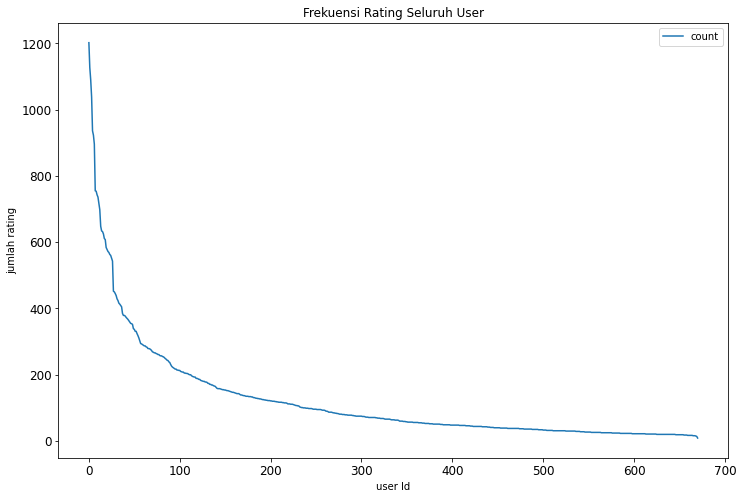

In [ ]:
# menghitung banyaknya rating yang diberikan setiap user
users_cnt = pd.DataFrame(ratings_drop_movies.groupby('userId').size(), columns=['count'])
# plot frekuensi rating seluruh movie
ax = users_cnt \
    .sort_values('count', ascending=False) \
    .reset_index(drop=True) \
    .plot(
        figsize=(12, 8),
        title='Frekuensi Rating Seluruh User',
        fontsize=12
    )
ax.set_xlabel("user Id")
ax.set_ylabel("jumlah rating")

In [ ]:
users_cnt['count'].quantile(np.arange(1, 0.3, -0.05))

1.00    1202.0
0.95     414.5
0.90     278.0
0.85     211.5
0.80     171.0
0.75     139.0
0.70     121.0
0.65     101.0
0.60      86.0
0.55      74.0
0.50      64.0
0.45      54.0
0.40      48.0
0.35      43.0
Name: count, dtype: float64

Grafik distribusi film (movie) tidak memiliki ekor yang sangat panjang, meskipun frekuensi rating masih cukup tinggi untuk sebagian kecil penonton. Dengan demikian kita dapat membatasi jumlah pengguna ke 60% teratas, yang telah memberi peringkat lebih dari 50 film.

In [ ]:
# filter data
ratings_thres = 50
active_users = list(set(users_cnt.query('count >= @ratings_thres').index))
ratings_drop_users = ratings_drop_movies[ratings_drop_movies.userId.isin(active_users)]
print('shape of original ratings data: ', ratings.shape)
print('shape of ratings data after dropping both unpopular movies and inactive users: ', ratings_drop_users.shape)

shape of original ratings data:  (100004, 4)
shape of ratings data after dropping both unpopular movies and inactive users:  (73223, 4)


# Train KNN model for item-based collaborative filtering
1. Reshaping the Data
2. Fitting the Model

<b>Reshaping the data</b>

Untuk K-Nearest Neighbors, data harus dalam array (artist, user), di mana setiap baris adalah film dan setiap kolom adalah pengguna yang berbeda. Untuk membentuk ulang kerangka data (dataframe), putar kerangka data ke format lebar dengan film sebagai baris dan pengguna sebagai kolom. Setiap nilai yang hilang dapat diperhitungkan dengan 0.

In [ ]:
final_dataset = ratings_drop_users.pivot(index='movieId',columns='userId',values='rating')
final_dataset.head()

userId,2,4,5,7,8,13,15,17,18,19,...,655,656,658,659,660,662,664,665,667,671
movieId,,,,,,,,,,,,,,,,,,,,,
1,NaN,NaN,NaN,3.0,NaN,5.0,2.0,NaN,NaN,3.0,...,NaN,NaN,NaN,NaN,2.5,NaN,3.5,NaN,NaN,5.0
2,NaN,NaN,NaN,NaN,NaN,NaN,2.0,NaN,NaN,3.0,...,4.0,NaN,NaN,NaN,NaN,5.0,NaN,3.0,NaN,NaN
3,NaN,NaN,4.0,NaN,NaN,NaN,NaN,NaN,NaN,3.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.0,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,NaN,NaN,NaN,NaN,NaN,NaN,4.5,NaN,3.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.0,NaN,NaN


In [ ]:
final_dataset.fillna(0,inplace=True)
final_dataset = final_dataset.reset_index()
final_dataset

userId,movieId,2,4,5,7,8,13,15,17,18,...,655,656,658,659,660,662,664,665,667,671
0,1,0.0,0.0,0.0,3.0,0.0,5.0,2.0,0.0,0.0,...,0.0,0.0,0.0,0.0,2.5,0.0,3.5,0.0,0.0,5.0
1,2,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,...,4.0,0.0,0.0,0.0,0.0,5.0,0.0,3.0,0.0,0.0
2,3,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0
3,4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,5,0.0,0.0,0.0,0.0,0.0,0.0,4.5,0.0,3.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2240,122904,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2241,134130,0.0,0.0,0.0,0.0,0.0,0.0,3.5,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2242,134853,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2243,139385,0.0,0.0,0.0,0.0,0.0,0.0,2.5,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


final_dataset kami memiliki dimensi 2269 * 378 di mana sebagian besar nilainya jarang. Sebagai indikasi, kita akan menghitung sparity dari dataset ini.

In [ ]:
sparsity = 1.0 - ( np.count_nonzero(final_dataset) / float(final_dataset.size) )
print(sparsity)

0.914025484310118


Untuk mengurangi sparsity matriks, kita dapat menggunakan csr_matrix scipy lib, yang kompatibel dengan sklearn.

In [ ]:
csr_data = csr_matrix(final_dataset.values)
print(csr_data)

  (0, 0)	1.0
  (0, 4)	3.0
  (0, 6)	5.0
  (0, 7)	2.0
  (0, 10)	3.0
  (0, 11)	3.5
  (0, 14)	3.0
  (0, 15)	5.0
  (0, 16)	4.0
  (0, 25)	4.0
  (0, 26)	4.0
  (0, 28)	4.0
  (0, 34)	5.0
  (0, 35)	3.0
  (0, 36)	4.0
  (0, 37)	5.0
  (0, 38)	5.0
  (0, 39)	3.5
  (0, 40)	5.0
  (0, 41)	3.0
  (0, 42)	4.0
  (0, 44)	2.0
  (0, 47)	3.5
  (0, 49)	3.0
  (0, 51)	5.0
  :	:
  (2242, 317)	4.0
  (2242, 363)	5.0
  (2242, 369)	4.5
  (2243, 0)	139385.0
  (2243, 7)	2.5
  (2243, 28)	4.0
  (2243, 39)	3.5
  (2243, 40)	4.0
  (2243, 149)	4.0
  (2243, 215)	4.0
  (2243, 220)	4.0
  (2243, 264)	3.5
  (2243, 282)	3.5
  (2243, 317)	3.5
  (2243, 363)	4.0
  (2244, 0)	148626.0
  (2244, 7)	3.5
  (2244, 28)	2.0
  (2244, 40)	3.5
  (2244, 139)	3.0
  (2244, 215)	4.0
  (2244, 276)	5.0
  (2244, 317)	4.5
  (2244, 332)	4.0
  (2244, 381)	3.0


Kami sekarang akan menyesuaikan model knn dengan sparse matriks kami dalam format csr. Dengan menentukan metric = cosine, model akan mengukur kesamaan antara vektor artis dengan menggunakan kesamaan cosinus.

Menggunakan jarak Euclidean tidak praktis, karena sebagian besar vektor artis memiliki nilai 0, dan koefisien Pearson jauh lebih lambat dibandingkan dengan kesamaan kosinus, yang telah kita gunakan di sini.

In [ ]:
# define model
knn = NearestNeighbors(metric='cosine', algorithm='brute', n_neighbors=20, n_jobs=-1)
# fit
knn.fit(csr_data)

NearestNeighbors(algorithm='brute', metric='cosine', n_jobs=-1, n_neighbors=20)

In [ ]:
def get_movie_recommendation(movie_name):
    n_movies_to_reccomend = 10
    movie_list = movies[movies['title'].str.contains(movie_name)]  
    if len(movie_list):        
        movie_idx= movie_list.iloc[0]['movieId']
        movie_idx = final_dataset[final_dataset['movieId'] == movie_idx].index[0]
        
        distances , indices = knn.kneighbors(csr_data[movie_idx],n_neighbors=n_movies_to_reccomend+1)    
        rec_movie_indices = sorted(list(zip(indices.squeeze().tolist(),distances.squeeze().tolist())),\
                               key=lambda x: x[1])[:0:-1]
        
        recommend_frame = []
        
        for val in rec_movie_indices:
            movie_idx = final_dataset.iloc[val[0]]['movieId']
            idx = movies[movies['movieId'] == movie_idx].index
            recommend_frame.append({'Title':movies.iloc[idx]['title'].values[0],'Distance':val[1]})
        df = pd.DataFrame(recommend_frame,index=range(1,n_movies_to_reccomend+1))
        return df
    
    else:
        
        return "No movies found. Please check your input"

In [ ]:
get_movie_recommendation('Iron Man')

,Title,Distance
1,300 (2007),1.062917e-07
2,Inception (2010),1.051794e-07
3,Iron Man 2 (2010),1.041543e-07
4,Guardians of the Galaxy (2014),1.032304e-07
5,"Dark Knight Rises, The (2012)",1.003167e-07
6,Sherlock Holmes (2009),9.985601e-08
7,"Avengers, The (2012)",9.484807e-08
8,"Dark Knight, The (2008)",9.195896e-08
9,Avatar (2009),8.435755e-08
10,Star Trek (2009),8.261235e-08


Recommender System ini bekerja dengan sempurna untuk kumpulan data yang diberikan. Namun, masalah sparity masih bertahan dalam algoritma knn yang dapat diperbaiki oleh ALS.